In [1]:

import models
import utils
import data_processing
from constants import (
    VALUE_COLUMN,
    UNIT_RATE_COLUMN,
    QUANTITY_COLUMN,
    GROSS_WEIGHT_COLUMN,
    SHIP_COUNT_COLUMN,
    PORT_COUNT_COLUMN,
    FILL_METHOD,
    TARGET_COLUMN,
    VOLZA_COLUMNS,
    AIS_COLUMNS,
    OIL_COLUMNS,
    ARIMA_RESIDUAL_COLUMN,
    RANDOM_STATE
)
import pandas as pd
import constants
import sys
from datetime import datetime
from build_data import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
import numpy as np

In [2]:
COMMODITY = "copper"
WINDOW_SIZE = 20

VOLZA_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}.csv"
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"

# Get the data
data = get_data(VOLZA_FILE_PATH, PRICE_FILE_PATH, window_size=20, center=False)

# Add Isolation Forest spikes column
data['spikes_if'] = utils.detect_spikes_if(data, [TARGET_COLUMN], contamination=0.1)

# TRAIN_SIZE = 0.5

Building data...


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={"Value": "Brent Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={"Value": "WTI Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:69: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

Rows dropped due to NaN values: 1
Detecting spikes... 20


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [3]:
import matplotlib.pyplot as plt

aggregated_df = data.copy()
data.head(2)

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if
1,2019-01-02,28997742.33,4504496.0,4507752.0,6.420416,NaN,NaN,NaN,2.6250,54.06,46.31,2.6250,0,0
2,2019-01-03,16525428.57,2427492.0,2428782.0,9.079466,NaN,NaN,NaN,2.5705,53.23,46.92,-0.0545,0,0


In [4]:
# Add Lagged Features
aggregated_df = utils.add_lagged_features(aggregated_df, 'Price', n_lags=5)

# Add Moving Averages
aggregated_df = utils.add_moving_averages(aggregated_df, 'Price', windows=[5, 10])

# Add Returns
aggregated_df = utils.add_returns(aggregated_df, 'Price')

# Add Volatility
aggregated_df = utils.add_volatility(aggregated_df, 'returns', windows=[7, 14])

Spike Percentage: 10.02%


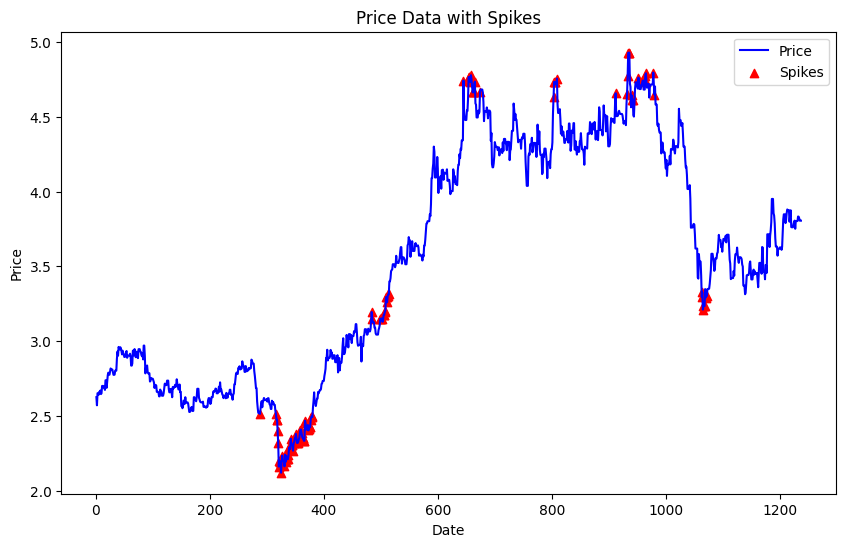

In [5]:
import matplotlib.pyplot as plt
# Plotting the price data
utils.plot_prices(aggregated_df,column='spikes_if')

In [6]:
PRICE_FEATURE_COLUMNS = ['ma_5', 'ma_10', 'returns']
PRICE_LAG_FEATURE_COLUMNS = ['lag_1', 'lag_2', 'lag_3']
FEATURE_COLUMNS = VOLZA_COLUMNS + OIL_COLUMNS + [ARIMA_RESIDUAL_COLUMN]
PRICE_COLUMN = ['Price']
TARGET_COLUMN = ['spikes_if']

In [7]:
from imblearn.over_sampling import RandomOverSampler

# Prepare mixed data
X_mix, y_mix = data_processing.prepare_features_and_target(aggregated_df, FEATURE_COLUMNS, TARGET_COLUMN)

# Split mixed data
X_train_mix, X_test_mix, y_train_mix, y_test_mix = train_test_split(X_mix, y_mix, test_size=0.3, random_state=RANDOM_STATE, shuffle=False)
X_train_mix, X_val_mix, y_train_mix, y_val_mix = train_test_split(X_train_mix, y_train_mix, test_size=(10/70), random_state=RANDOM_STATE, shuffle=False)  # Adjusting test_size to get ~10% of the original

# Balancing
X_train_mix, y_train_mix = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train_mix, y_train_mix)

# Scaling
X_train_mix, X_test_mix, X_val_mix = data_processing.scale_features(X_train_mix, X_test_mix, X_val_mix)

# Sequence making
X_train_mix, y_train_mix = data_processing.create_sequences(X_train_mix, y_train_mix, WINDOW_SIZE)
X_test_mix, y_test_mix = data_processing.create_sequences(X_test_mix, y_test_mix, WINDOW_SIZE)
X_val_mix, y_val_mix = data_processing.create_sequences(X_val_mix, y_val_mix, WINDOW_SIZE)

# Evaluate and create pre-trained model
output_file_path = f'{COMMODITY}/test/results_test.csv'
pred_file_path = f'{COMMODITY}/test/predictions/test'
model_path = f'{COMMODITY}/best_model'
print(pred_file_path)
results_df, best_acc, best_model_descriptor = models.evaluate_all(X_train_mix, y_train_mix, X_val_mix, y_val_mix, X_test_mix, y_test_mix, output_file_path, pred_file_path, model_path)

copper/test/predictions/test



12/12 [==============================] - 0s 3ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_256_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_256_layers_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 2ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_128_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_128_layers_predictions.npy
12/12 [==============================] - 0s 2ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_64_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_64_layers_predictions.npy
12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_32_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_32_layers_predictions.npy


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 942us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.npy
12/12 [==============================] - 0s 927us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 840us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 946us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.npy
12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.npy
12/12 [==============================] - 0s 975us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.npy
12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 916us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.npy
12/12 [==============================] - 0s 2ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_256_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_256_units_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_128_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_128_units_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_64_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_64_units_predictions.npy
12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_32_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_32_units_predictions.npy
12/12 [==============================] - 0s 958us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_32_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_32_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 891us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_32_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_32_filters_5_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 905us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_32_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_32_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_64_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_64_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 752us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_64_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_64_filters_5_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 797us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_64_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_64_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_128_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_128_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_128_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_128_filters_5_kernels_predictions.npy
12/12 [==============================] - 0s 978us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_128_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_128_filters_3_kernels_predictions.npy
12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_256_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_256_filters_7_kernels_predictions.npy
12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_256_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_256_filt

c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
print(f'Best Model: {best_model_descriptor} \nBest Accuracy: {best_acc}')

Best Model: LSTM_256_layers 
Best Accuracy: 0.9291784702549575


In [9]:
PRICE_COLUMN = VOLZA_COLUMNS + OIL_COLUMNS + [ARIMA_RESIDUAL_COLUMN]

In [10]:
# Prepare price data
X_price, y_price = data_processing.prepare_features_and_target(aggregated_df, PRICE_COLUMN, TARGET_COLUMN)

# Split price data
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.3, random_state=RANDOM_STATE, shuffle=False)
X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(X_train_price, y_train_price, test_size=(10/70), random_state=RANDOM_STATE, shuffle=False)

# Balancing
X_train_price, y_train_price = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train_price, y_train_price)

# Scaling
X_train_price, X_test_price, X_val_price = data_processing.scale_features(X_train_price, X_test_price, X_val_price)

# Sequence making
X_train_price, y_train_price = data_processing.create_sequences(X_train_price, y_train_price, WINDOW_SIZE)
X_test_price, y_test_price = data_processing.create_sequences(X_test_price, y_test_price, WINDOW_SIZE)
X_val_price, y_val_price = data_processing.create_sequences(X_val_price, y_val_price, WINDOW_SIZE)

In [11]:
from tensorflow.keras.models import load_model

saved_model_path = f'{model_path}/{best_model_descriptor}.h5'
model = load_model(saved_model_path)
# model.summary()


In [12]:
print(X_train_price.shape, X_val_price.shape, X_test_price.shape)
print(X_train_mix.shape, X_val_mix.shape, X_test_mix.shape)

(1275, 20, 6) (105, 20, 6) (353, 20, 6)
(1275, 20, 6) (105, 20, 6) (353, 20, 6)


In [13]:
results_df = models.retrain_best_model(saved_model_path, X_train_price, y_train_price, X_val_price, y_val_price, X_test_price, y_test_price)

12/12 [==============================] - 0s 5ms/step


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [14]:
results_df

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Prior
0,Retrained Model,LSTM_256_layers,0.929178,0.929178,1.0,0.963289,0.0,0.0,0.0,0.07
